#Question 1 - Part 1 - Loading Dataset

In [9]:
import os
import gdown
import tensorflow as tf
from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

Downloading Stanford Cars Dataset from Kaggle

In [11]:
!pip install -q kaggle
!mkdir ~/.kaggle
!wget https://raw.githubusercontent.com/ms03831/cv_a2/main/kaggle.json
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

--2021-05-29 18:28:07--  https://raw.githubusercontent.com/ms03831/cv_a2/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      70  --.-KB/s    in 0s      

2021-05-29 18:28:07 (4.31 MB/s) - ‘kaggle.json’ saved [70/70]

 99% 1.81G/1.82G [00:16<00:00, 46.7MB/s]
100% 1.82G/1.82G [00:16<00:00, 118MB/s] 


Unzipping

In [12]:
os.makedirs("images_cars")
with ZipFile("/content/stanford-cars-dataset.zip", "r") as zipobj:
    zipobj.extractall("images_cars")

#Question 1 - Part 2 - Discriminator

In [14]:
def define_discriminator(in_shape=(32,32,1)):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # define model
  model = Sequential()

  model.add(Conv2D(32, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))

  # classifier
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt = Adam(lr=0.00012, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

The architecture has three Conv2D layers with LeakyReLU activation function and then outputs a single error between 0 to 1 using sigmoid. 

MaxPooling is not used because it is not preferable in GANs. Also, this is a very basic CNN which ensures fast training.

When deciding an architecture for discriminator, a common convention is increasing filters as we go deeper into the network. The deeper layers in the network are responsible for learning the more complex patterns, shapes, or representations of the image. The more complex features mean that we need to capture more combinations, hence more filters.

#Question 1 - 3 - Generator

In [15]:
def define_generator(latent_dim):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # define model
  model = Sequential()

  # foundation for 4x4 image
  n_nodes = 128 * 4 * 4
  model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 128)))
   
  #upsampling to 8x8 
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))

  #upsampling to 16x16 
  model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))
 
  #upsampling to 32x32  
  model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))

  # output 32x32x1
  model.add(Conv2D(1, (5,5), activation='tanh', padding='same', kernel_initializer=init))
  return model

In [11]:
#Implementing the Generator network to accept 100x1 noise vector and output 64x64x3 image
latent_dim = 100

The input noise vector dimension can certainly be changed. 

The vector is drawn randomly from a Gaussian distribution, and the vector is used to seed the generative process. After training, points in this multidimensional vector space will correspond to points in the problem domain, forming a compressed representation of the data distribution.

The generator model applies meaning to points in a chosen latent space, such that new points drawn from the latent space can be provided to the generator model as input and used to generate new and different output examples. 

A large set of random numbers mean that more output images of different variety can be generated by the GAN. 

A very large number is not chosen because it can make the training very difficult and would require a much better discriminator as well as a generator. 

The number is not decreased too much because that would mean forcing the model to only generate a small subset of plausible outputs. This would eventually cause **Mode Collapse** failure in the GAN.

A good starting point for generator in terms of deciding the number of filters could be reversing the order of the number of filters of the discriminator and that is what we did here. 

For example, if the discriminator starts from 32 filters, then 64, then 128. So, for generator, we went from 128 to 64 to 32. You can read the original DCGAN paper, and see their architecture. 

#Question 1 - 4 - Training Loop for GAN

In [16]:
from os import makedirs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from matplotlib import pyplot
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

Hyperparameters

In [17]:
EPOCHS = 50
BATCH_SIZE = 128
lr = 0.00012
latent_dim = 100

Sources Used: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

In [18]:
# load images
def load_real_samples():
  data = list()
  # load dataset
  for filename in os.listdir('/content/images_cars/cars_train/cars_train/'):
    pixels = load_img('/content/images_cars/cars_train/cars_train/'+str(filename), target_size = (32,32), grayscale=True)
    pixels = img_to_array(pixels)
    data.append(pixels)

  X = asarray(data)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1] to match the generator images
  X = (X - 127.5) / 127.5
  return X

In [19]:
X = load_real_samples()
print(X.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(8144, 32, 32, 1)


(32, 32, 1)
(32, 32, 3)


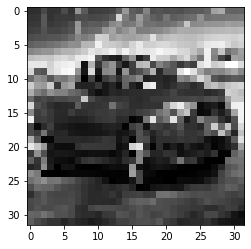

In [48]:
from PIL import Image
from matplotlib import pyplot as plt
import cv2

print(X[0].shape) #converting for the sake of plotting
backtorgb = cv2.cvtColor(X[0],cv2.COLOR_GRAY2RGB)
print(backtorgb.shape)
#pyplot.imshow(backtorgb)
pyplot.imshow((backtorgb+1)/2) #we are actually using 1 channel image, this is just for plotting

In [57]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
  # make weights in the discriminator not trainable
  discriminator.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(generator)
  # add the discriminator
  model.add(discriminator)
  # compile model
  opt = Adam(lr=0.00012, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # select images
  X = dataset[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = generator.predict(x_input)
  # create class labels
  y = zeros((n_samples, 1))
  return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=16):
  # prepare fake examples
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot images
  for i in range(4 * 4):
    # define subplot
    pyplot.subplot(4, 4, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    backtorgb = cv2.cvtColor(X[i, :, :, :],cv2.COLOR_GRAY2RGB)
    pyplot.imshow((backtorgb+1)/2)
  # save plot to file
  pyplot.savefig('results_baseline/generated_plot_%03d.png' % (step+1))
  pyplot.close()
  # save the generator model
  g_model.save('/content/drive/MyDrive/CV_Assignment_02/model_%03d.h5' % (step+1))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.plot(d1_hist, label='d-real')
  pyplot.plot(d2_hist, label='d-fake')
  pyplot.plot(g_hist, label='gen')
  pyplot.legend()
  # plot discriminator accuracy
  pyplot.subplot(2, 1, 2)
  pyplot.plot(a1_hist, label='acc-real')
  pyplot.plot(a2_hist, label='acc-fake')
  pyplot.legend()
  # save plot to file
  pyplot.savefig('results_baseline/plot_line_plot_loss.png')
  pyplot.close()

In [52]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=EPOCHS, n_batch=BATCH_SIZE):
  # calculate the number of batches per epoch
  bat_per_epo = int(dataset.shape[0] / n_batch)
  # calculate the total iterations based on batch and epoch
  n_steps = bat_per_epo * n_epochs
  # calculate the number of samples in half a batch
  half_batch = int(n_batch / 2)
  # prepare lists for storing stats each iteration
  d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
  # manually enumerate epochs
  for i in range(n_steps):
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator model weights
    d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
    # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator model weights
    d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
    # prepare points in latent space as input for the generator
    X_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator's error
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
    # summarize loss on this batch
    print('>%d, disc_1(Real)=%.3f, disc_2(Fake)=%.3f, gen_loss=%.3f, disc_1(Real)_a=%d, disc_2(Fake)_a=%d' %
      (i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
    # record history
    d1_hist.append(d_loss1)
    d2_hist.append(d_loss2)
    g_hist.append(g_loss)
    a1_hist.append(d_acc1)
    a2_hist.append(d_acc2)
    # evaluate the model performance every 'epoch'
    if (i+1) % bat_per_epo == 0:
      summarize_performance(i, g_model, latent_dim)
  plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
  return d1_hist, d2_hist, g_hist, a1_hist, a2_hist

In [42]:
makedirs('results_baseline', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(8144, 32, 32, 1)


Final training

In [58]:
d1_hist2, d2_hist2, g_hist2, a1_hist2, a2_hist2 = train(generator, discriminator, gan_model, dataset, latent_dim)

>1, disc_1(Real)=0.248, disc_2(Fake)=0.675, gen_loss=0.803, disc_1(Real)_a=100, disc_2(Fake)_a=92
>2, disc_1(Real)=0.229, disc_2(Fake)=0.575, gen_loss=0.902, disc_1(Real)_a=100, disc_2(Fake)_a=100
>3, disc_1(Real)=0.233, disc_2(Fake)=0.502, gen_loss=1.008, disc_1(Real)_a=100, disc_2(Fake)_a=100
>4, disc_1(Real)=0.206, disc_2(Fake)=0.436, gen_loss=1.129, disc_1(Real)_a=100, disc_2(Fake)_a=100
>5, disc_1(Real)=0.197, disc_2(Fake)=0.385, gen_loss=1.234, disc_1(Real)_a=98, disc_2(Fake)_a=100
>6, disc_1(Real)=0.194, disc_2(Fake)=0.350, gen_loss=1.301, disc_1(Real)_a=96, disc_2(Fake)_a=100
>7, disc_1(Real)=0.181, disc_2(Fake)=0.336, gen_loss=1.315, disc_1(Real)_a=93, disc_2(Fake)_a=100
>8, disc_1(Real)=0.124, disc_2(Fake)=0.337, gen_loss=1.299, disc_1(Real)_a=98, disc_2(Fake)_a=100
>9, disc_1(Real)=0.142, disc_2(Fake)=0.352, gen_loss=1.264, disc_1(Real)_a=98, disc_2(Fake)_a=100
>10, disc_1(Real)=0.133, disc_2(Fake)=0.370, gen_loss=1.201, disc_1(Real)_a=96, disc_2(Fake)_a=100
>11, disc_1(Real

#Question 1 - Part 5

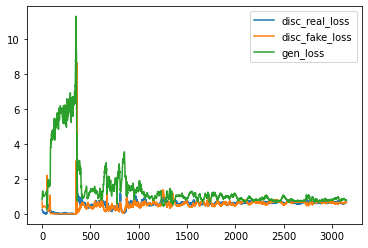

In [59]:
pyplot.plot(d1_hist2, label='disc_real_loss')
pyplot.plot(d2_hist2, label='disc_fake_loss')
pyplot.plot(g_hist2, label='gen_loss')
pyplot.legend()

From the results we can see that after first 500 steps, the generator is not letting the discriminator win and viceversa. Both of their accuracies are increasing above 50 and then decreasing in the next steps such that both of them have the same losses.

As we can see from the above figure, all three losses are converging smoothly and the model is thus stable.

#Question 1 - Part 6

In [101]:
def generate_samples(n):
  x_input = generate_latent_points(latent_dim, n)
	# predict outputs
  X = generator.predict(x_input)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot images
  for i in range(n):
    # define subplot
    pyplot.subplot(1,n,i+1)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    backtorgb = cv2.cvtColor(X[i, :, :, :],cv2.COLOR_GRAY2RGB)
    pyplot.imshow((backtorgb+1)/2)

In [100]:
generate_samples(20)

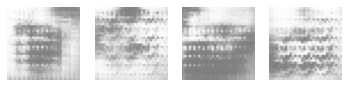

In [102]:
generate_samples(4)

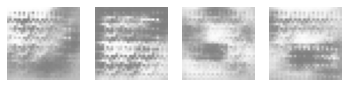

In [94]:
generate_samples(4)

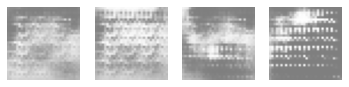

In [95]:
generate_samples(4)

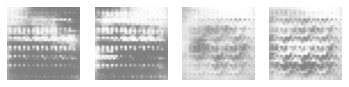

In [96]:
generate_samples(4)

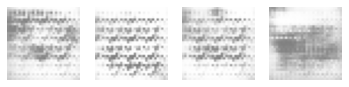

In [97]:
generate_samples(4)

The produced images show that the generator was not trained properly. 

You can also see this during the first 500 steps of the loss plot where generator loss increases significantly and then converges.

If the GAN is run for more epochs, then the results may improve.

#Question 1 - Part 7 - Transfer Learning

#Part a

Yes, we can use a pre-trained VGG-16 network for the above defined GAN.

Yes, the resulting network would be a DCGAN and VGG-16 is DCNN.

VGG-16 is used in classification and not upsampling or deconvolution, hence it cannot be used in generator, but it can be used in a discriminator which can classofy real or fake.

The network architecture of the discriminator will have to be modified. 

VGG-16 model will be imported that has been pre-trained on ImageNet. All the layers will be imported except the last layer, instead a few fully connected dense layers will be connected on the output side, and only these layers will trained again on the Stanford Cars dataset. 

Earlier layers of the network usually extract minor features like edges and contrast differences which are present in all the images, and outer layers extract more prominent features like wheels, mirrors, headlights etc. Therefore only the newly added layers will need to be trained. 

This way the discriminator will be more efficient. The generator remains same.

The number of networks in the overall architecture remain two.

#Part b

As elaborated in the above part VGG-16 is only suitable for the discriminator as it does not upsample/tranpose convolution/deconvolution but has convolutional layers and uses them to extract feautures and classify - which is the job of the discriminator.

VGG-16 cannot be used as a generator because of its architecture. It inputs images and outputs numbers, while a generator should input numbers and output images. 

Reiterating, convolutional layers are used in VGG-16 which downsamples an image by extracting feature maps from them which is the opposite of a generator which takes a random number list from a gaussian distribution and upsamples it into an image.

#Part c - Implementation

Since VGG16 takes 3 channel inputs, we are proceeding with a 32x32x3 image

In [7]:
import matplotlib.pyplot as plt
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras import optimizers
from keras.layers import LeakyReLU
from keras import Model
from os import makedirs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from matplotlib import pyplot
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

In [108]:
# load images
def load_real_samples():
  data = list()
  # load dataset
  for filename in os.listdir('/content/images_cars/cars_train/cars_train/'):
    pixels = load_img('/content/images_cars/cars_train/cars_train/'+str(filename), target_size = (32,32))
    pixels = img_to_array(pixels)
    data.append(pixels)

  X = asarray(data)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1] to match the generator images
  X = (X - 127.5) / 127.5
  return X

In [115]:
X = load_real_samples()
print(X.shape)

(8144, 32, 32, 3)


(32, 32, 3)


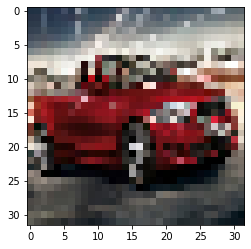

In [116]:
from PIL import Image
from matplotlib import pyplot as plt
import cv2

print(X[0].shape) 

pyplot.imshow((X[0]+1)/2) 

In [119]:
EPOCHS = 50 #same hyperparameters as before so we can compare results and the effect of VGG-16
BATCH_SIZE = 128
lr = 0.00012
latent_dim = 100

In [130]:
#Defining the CNN based discriminator model
def define_discriminator(in_shape=(32,32,3)):
  # weight initialization
  init = RandomNormal(stddev=0.02)
 
	#Importing VGG Network without Classifier Layer
  base_model = vgg.VGG16(weights='imagenet', include_top=False, input_shape=in_shape)

  # Extract the last layer from third block of vgg16 model
  last = base_model.get_layer('block3_pool').output

  # Add classification layers on top of it
  x = BatchNormalization()(last)
  x = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.7)(x)
  x = Flatten()(x)

  pred = Dense(1, activation='sigmoid')(x)
  model = Model(base_model.input, pred)

  #Freezing the layers of VGG network to make them untrainable
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.00012, beta_1=0.5), metrics=['accuracy'])
  return model

#Implementing the Generator network to accept 100x1 noise vector and output 64x64x3 image
latent_dim = 100

def define_generator(latent_dim):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # define model
  model = Sequential()
  # foundation for 8x8 image
  n_nodes = 128 * 8 * 8
  model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 8, 128)))
 
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))
 
  model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.2))
 
  # output 32x32x3
  model.add(Conv2D(3, (5,5), activation='tanh', padding='same', kernel_initializer=init))
  return model

  # define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.00012, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

  # select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=16):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(4 * 4):
		# define subplot
		pyplot.subplot(4, 4, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, :])
	# save plot to file
	pyplot.savefig('results_baseline/generated_plot_%03d.png' % (step+1))
	pyplot.close()
	# save the generator model
	g_model.save('/content/drive/MyDrive/CV_Assignment_02/model_%03d.h5' % (step+1))
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d1_hist, label='d-real')
	pyplot.plot(d2_hist, label='d-fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	# plot discriminator accuracy
	pyplot.subplot(2, 1, 2)
	pyplot.plot(a1_hist, label='acc-real')
	pyplot.plot(a2_hist, label='acc-fake')
	pyplot.legend()
	# save plot to file
	pyplot.savefig('results_baseline/plot_line_plot_loss.png')
	pyplot.close()
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=EPOCHS, n_batch=256):
  # calculate the number of batches per epoch
  bat_per_epo = int(dataset.shape[0] / n_batch)
  # calculate the total iterations based on batch and epoch
  n_steps = bat_per_epo * n_epochs
  # calculate the number of samples in half a batch
  half_batch = int(n_batch / 2)
  # prepare lists for storing stats each iteration
  d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
  # manually enumerate epochs
  for i in range(n_steps):
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator model weights
    d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
    # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator model weights
    d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
    # prepare points in latent space as input for the generator
    X_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator's error
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
    # summarize loss on this batch
    print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
      (i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
    # record history
    d1_hist.append(d_loss1)
    d2_hist.append(d_loss2)
    g_hist.append(g_loss)
    a1_hist.append(d_acc1)
    a2_hist.append(d_acc2)
    # evaluate the model performance every 'epoch'
    if (i+1) % bat_per_epo == 0:
      summarize_performance(i, g_model, latent_dim)
  plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
  return d1_hist, d2_hist, g_hist, a1_hist, a2_hist

In [131]:
# make folder for results
makedirs('results_baseline', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(8144, 32, 32, 3)


In [132]:
d1_hist3, d2_hist3, g_hist3, a1_hist3, a2_hist3 = train(generator, discriminator, gan_model, dataset, latent_dim)

>1, d1=0.630, d2=0.726 g=0.517, a1=63, a2=43
>2, d1=0.538, d2=0.528 g=0.589, a1=87, a2=86
>3, d1=0.513, d2=0.426 g=0.633, a1=86, a2=96
>4, d1=0.452, d2=0.339 g=0.667, a1=95, a2=100
>5, d1=0.427, d2=0.286 g=0.699, a1=91, a2=98
>6, d1=0.385, d2=0.230 g=0.789, a1=96, a2=99
>7, d1=0.345, d2=0.215 g=0.777, a1=98, a2=100
>8, d1=0.319, d2=0.220 g=0.803, a1=99, a2=98
>9, d1=0.278, d2=0.206 g=0.819, a1=98, a2=100
>10, d1=0.251, d2=0.178 g=0.822, a1=98, a2=99
>11, d1=0.256, d2=0.158 g=0.886, a1=98, a2=99
>12, d1=0.224, d2=0.120 g=0.888, a1=99, a2=100
>13, d1=0.197, d2=0.170 g=0.897, a1=98, a2=99
>14, d1=0.172, d2=0.165 g=0.945, a1=100, a2=100
>15, d1=0.189, d2=0.159 g=0.886, a1=98, a2=100
>16, d1=0.141, d2=0.170 g=0.980, a1=100, a2=99
>17, d1=0.147, d2=0.139 g=1.235, a1=99, a2=100
>18, d1=0.150, d2=0.106 g=1.311, a1=99, a2=100
>19, d1=0.151, d2=0.087 g=1.364, a1=99, a2=99
>20, d1=0.114, d2=0.096 g=1.412, a1=99, a2=100
>21, d1=0.108, d2=0.084 g=1.470, a1=99, a2=100
>22, d1=0.088, d2=0.077 g=1.452

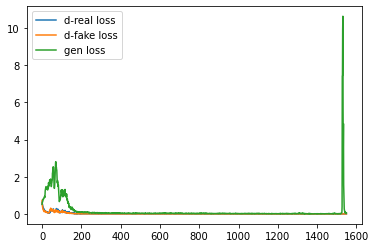

In [133]:
pyplot.figure(1)
pyplot.plot(d1_hist3, label='d-real loss')
pyplot.plot(d2_hist3, label='d-fake loss')
pyplot.plot(g_hist3, label='gen loss')
pyplot.legend()

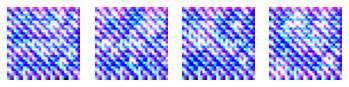

In [134]:
def generate_samples(n):
  x_input = generate_latent_points(latent_dim, n)
	# predict outputs
  X = generator.predict(x_input)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot images
  for i in range(n):
    # define subplot
    pyplot.subplot(1, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(X[i, :, :, :])
generate_samples(4)

Using VGG-16 in the discriminator - the results are comparitively worse as compared to my GAN model before.

We see an overly trained discriminator on real and fake images based on the loss plots - so the GAN is unstable - worse as compared to my previous model.

The reason being of overtrained and exceptionally efficient VGG-16 which makes the discriminator over-efficient and so it affects the generator adversely. We end up with high generator loss.

The discriminator becomes too good at identifying the fake images from true images.

If the discriminator becomes too good, then generator training can fail due to vanishing gradients. In effect, an optimal discriminator doesn't provide enough information for the generator to make progress. Therefore, the generator is not able to produce clear images as visible from the generate_sample function in the above cell.

In a stable GAN, discriminator loss is around 0.5 while generator loss can be between 0.7 to even 2. This is not the case here.

#Question 1 - Part 8 - Bonus - LsGAN

Earlier we implemented a type of Vanilla GAN called a DCGAN.

Vanilla GANs has two networks called generator network and a discriminator network. Both the networks are trained at the same time and compete or battle against each other in a minimax play.

In regular GAN, the discriminator uses cross-entropy loss function which sometimes leads to vanishing gradient problems. Instead of that LsGAN proposes to use the least-squares loss function for the discriminator. This formulation provides a higher quality of images generated by GAN.

In this part, we will try to implement LsGAN on the Car dataset. 

Code Inspired from: https://machinelearningmastery.com/least-squares-generative-adversarial-network/

Inspired from: https://neptune.ai/blog/6-gan-architectures

Github: https://github.com/xudonmao/LSGAN

Research Paper: https://arxiv.org/pdf/1611.04076.pdf

The Least Squares Generative Adversarial Network, or LSGAN for short, is an extension to the GAN architecture that addresses the problem of vanishing gradients and loss saturation.

It is motivated by the desire to provide a signal to the generator about fake samples that are far from the discriminator model’s decision boundary for classifying them as real or fake. The further the generated images are from the decision boundary, the larger the error signal provided to the generator, encouraging the generation of more realistic images.

The LSGAN can be implemented with a minor change to the output layer of the discriminator layer and the adoption of the least squares, or L2, loss function.

In [5]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from matplotlib import pyplot

In [2]:
# load images
def load_real_samples():
  data = list()
  # load dataset
  for filename in os.listdir('/content/images_cars/cars_train/cars_train/'):
    pixels = load_img('/content/images_cars/cars_train/cars_train/'+str(filename), target_size = (64,64))
    pixels = img_to_array(pixels)
    data.append(pixels)

  X = asarray(data)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1] to match the generator images
  X = (X - 127.5) / 127.5
  return X

In [26]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='linear', kernel_initializer=init))
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

  # define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 16x16 image
	n_nodes = 256 * 16 * 16
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Reshape((16, 16, 256)))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# upsample to 64x64
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# output 64x64x3
	model.add(Conv2D(3, (7,7), padding='same', kernel_initializer=init))
	model.add(Activation('tanh'))
	return model

  # define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	for layer in discriminator.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

  # select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

  # generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

  # use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

  # generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('Saved %s and %s' % (filename1, filename2))
 

 
def plot_history(d1_hist, d2_hist, g_hist):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.plot(d1_hist, label='d-real')
  pyplot.plot(d2_hist, label='d-fake')
  pyplot.plot(g_hist, label='gen')
  pyplot.legend()
  pyplot.close()
 
 # train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=64):
  # calculate the number of batches per training epoch
  bat_per_epo = int(dataset.shape[0] / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # calculate the size of half a batch of samples
  half_batch = int(n_batch / 2)
  # lists for storing loss, for plotting later
  d1_hist, d2_hist, g_hist = list(), list(), list()
  # manually enumerate epochs
  for i in range(n_steps):
    # prepare real and fake samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator model
    d_loss1 = d_model.train_on_batch(X_real, y_real)
    d_loss2 = d_model.train_on_batch(X_fake, y_fake)
    # update the generator via the discriminator's error
    z_input = generate_latent_points(latent_dim, n_batch)
    y_real2 = ones((n_batch, 1))
    g_loss = gan_model.train_on_batch(z_input, y_real2)
    # summarize loss on this batch
    print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
    # record history
    d1_hist.append(d_loss1)
    d2_hist.append(d_loss2)
    g_hist.append(g_loss)
    # evaluate the model performance every 'epoch'
    if (i+1) % (bat_per_epo * 1) == 0:
      summarize_performance(i, g_model, latent_dim)
  # create line plot of training history
  plot_history(d1_hist, d2_hist, g_hist)
  return d1_hist, d2_hist, g_hist

Final Training on LsGAN with Stanford Cars Dataset of size 64x64x3

In [13]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(8144, 64, 64, 3)


Running the code below will report the loss of the discriminator on real (d1) and fake (d2) examples and the loss of the generator via the discriminator on generated examples presented as real (g).

These scores are printed at the end of each training run and are expected to remain small values throughout the training process. Values of zero for an extended period may indicate a failure mode and the training process should be restarted.

In [23]:
d1_hist, d2_hist, g_hist = train(generator, discriminator, gan_model, dataset, latent_dim)

>1, d1=0.069, d2=0.050 g=0.421
>2, d1=0.059, d2=0.032 g=0.456
>3, d1=0.053, d2=0.042 g=0.600
>4, d1=0.100, d2=0.020 g=0.373
>5, d1=0.086, d2=0.028 g=0.484
>6, d1=0.040, d2=0.035 g=0.484
>7, d1=0.078, d2=0.043 g=0.400
>8, d1=0.064, d2=0.034 g=0.348
>9, d1=0.079, d2=0.029 g=0.494
>10, d1=0.035, d2=0.050 g=0.355
>11, d1=0.051, d2=0.052 g=0.257
>12, d1=0.039, d2=0.050 g=0.484
>13, d1=0.091, d2=0.027 g=0.239
>14, d1=0.109, d2=0.015 g=0.444
>15, d1=0.072, d2=0.030 g=0.261
>16, d1=0.020, d2=0.034 g=0.196
>17, d1=0.046, d2=0.019 g=0.220
>18, d1=0.027, d2=0.027 g=0.252
>19, d1=0.028, d2=0.028 g=0.309
>20, d1=0.055, d2=0.028 g=0.206
>21, d1=0.058, d2=0.051 g=0.311
>22, d1=0.039, d2=0.043 g=0.365
>23, d1=0.050, d2=0.045 g=0.213
>24, d1=0.055, d2=0.037 g=0.283
>25, d1=0.038, d2=0.028 g=0.323
>26, d1=0.071, d2=0.034 g=0.246
>27, d1=0.029, d2=0.021 g=0.262
>28, d1=0.024, d2=0.037 g=0.238
>29, d1=0.052, d2=0.037 g=0.186
>30, d1=0.028, d2=0.040 g=0.278
>31, d1=0.036, d2=0.050 g=0.258
>32, d1=0.035, d2

Generate Images Using Generator

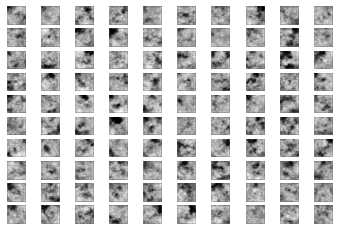

In [24]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create a plot of generated images (reversed grayscale)
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('model_002540.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
plot_generated(X, 10)

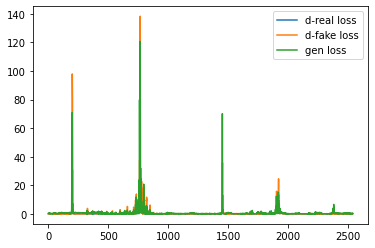

In [29]:
pyplot.figure(1)
pyplot.plot(d1_hist, label='d-real loss')
pyplot.plot(d2_hist, label='d-fake loss')
pyplot.plot(g_hist, label='gen loss')
pyplot.legend()

As we can see from the loss graph and the generated car images from the trained generator - this is the worst of the three models (the other two being my DCGAN and VGG GAN using transfer learning)

The loss of generator and discriminator is not converging at all.

The generated images are pure noise.

The Least Squares Generative Adversarial Network, or LSGAN for short, is an extension to the GAN architecture proposed by Xudong Mao, et al. in their 2016 paper titled “Least Squares Generative Adversarial Networks.” The LSGAN is a modification to the GAN architecture that changes the loss function for the discriminator from binary cross entropy to a least squares loss.

The motivation for this change is that the least squares loss will penalize generated images based on their distance from the decision boundary. This will provide a strong gradient signal for generated images that are very different or far from the existing data and address the problem of saturated loss.

As it turns out, this type of GAN is even worse, and requires more fine tuning which could not be done due to time constraints.

#Question 2 - Part 1

The student applied the sufficiently large median blurring filter to remove noise from the original images given by the researcher. 

Since the kernel/filter was large,original images were shrinked. Padding was done to retain the size of the original image. Now, the student has a batch of low resolution images and he wants to scale them upto the original HD image size (size is known).

**SRGANs can be used in this scenario**

Inspired from: https://paperswithcode.com/method/srgan

Super-Resolution Generative Adversarial Network, or SRGAN, is a Generative Adversarial Network (GAN) that can generate super-resolution images from low-resolution images, with finer details and higher quality.

SRGAN performs the challenging task of estimating a highresolution (HR) image from its low-resolution (LR) counterpart is referred to as super-resolution (SR). To achieve a photo-realistic effect in high resolution images, the network uses a perceptual loss function which consists of an adversarial loss and a content loss. It also uses a deep residual network to protect the minor details from getting lost in the down sampling process.

#Question 2 - Part 2

In this problem for skin matching, we do not have paired images of regular bears and pandas that can be used. A different set of images of bears and pandas is available. This problem may be handled by:

1. CGANS
2. CycleGAN

CGANs require a large dataset. Moreoever, a CGAN learns by figuring out the mapping of image X to image Y, and then is able to apply this mapping function on previously unseen data. Since, a CGAN requires a paired set of images for pandas and bears, which we do not have, it cannot be used.

The CycleGAN is a technique that involves the automatic training of image-to-image translation models without paired examples. The models are trained in an unsupervised manner using a collection of images from the source and target domain that do not need to be related in any way.

Inspired from: https://machinelearningmastery.com/what-is-cyclegan/#:~:text=The%20CycleGAN%20is%20a%20technique,be%20related%20in%20any%20way.

A CycleGAN is able to perform unpaired image-to-image translation by using a network of two discriminators and two generators. CycleGANs also learn mapping of image X to image Y, however they don't need the images to be exact same copies of each other with stylistic difference, as long as images are from the same domain.

Hence CycleGANs are the way to go for this problem!

##Question 2 - Part 3

The daughter wants to turn her family photos to a painting style of a famous painter to impress her mother. Two GANS may be used for this purpose:

1. CycleGAN
2. Style transfer GAN

A CycleGAN may work as it needs Van Gogh paintings and family photos at input. And those images do not have to be exact copy of one another. So a CycleGAN seems to work too.

However, I feel that a Style transfer GAN is a more suitable choice.

Style transfer is the task of changing the style of an image in one domain to the style of an image in another domain.

Inspired from: https://paperswithcode.com/task/style-transfer

It gives the option of masking which means more control over how much style is transferred on the input image unlike CycleGAN. 

The Style Transfer GAN uses generator network based on VGG-based CNN encoder-decoder using skip connections to transmit minor details to the output image. The discriminator is a patch based model which calculated the loss of an image in patches.

For training the Style transfer GAN, Behance dataset which is a large scale dataset of artistic images with category labels and styles can be used. 

#Question 3 - Bonus

The idea of an LSTM in the DC-GAN was inspired from: https://arxiv.org/pdf/1806.03027.pdf

For this particular problem, I have two things in mind for the architecture:

1. CNN for DC-GAN
2. LSTM for series prediction or for next image prediction in the discriminator.

Preprocessing: 

It would be really very important for a machine learning researcher or a programmer to first remove all the noise as well as distortion present within the video data by enhancing their contrast so that only that information that is required for the training of the model would be present within the video data
and there would be no noise within the data and hence the training, as well as the convergence of the model, becomes faster and more efficient.

The frames would be extracted from the videos present within the dataset and then these frames would be processed for the texture as well as appearances by making use of the libraries such as OpenCV, and cv2 of Python, or the image processing toolbox by MATLAB. Once these frames are extracted and preprocessed properly, a dataset would be prepared of these frames to train the models. 

These methods of preprocessing would include the stretching of the contrast within the images so that the objects within the image can be clearly identied, smoothing the image by filtering it so that there is uniformity within the image and the noise is removed from it, and so on.

Architecture:

A CNN and LSTM would have to be used alongside the GANs to better process the visual data in the discriminator section of the model where the model would try to differentiate between which frame is a fighting scene and which is not. 

Therefore, there has to be a combined CNN-LSTM-GAN model that has to be deployed in order to predict the frames perfectly using this visual data.

Our Proposed Model:

Input -> LSTM -> Generator -> CNN Discriminator 

The final output will be by the generator. It will be trained by feedback from LSTM and CNN.

Before the generator, an LSTM network structure enables learned semantics to correlate more closely with high-level visual features of images, which gives the generator more flexibility to add details to improve the visual quality of the synthesized images. The generator would make use of the ReLU activation function to get a better calculation of the gradients during the training phase in its neural layer while it would use the tanh function in its output layer.
The discriminator is supposed to use the Leaky ReLU activation function to reduce the chances of vanishing gradient during the training phase.

The generator would make use of the fractionally stridden convolutional layers in place of the pooling layers to perform the feature extraction. The discriminator would make use of the stridden convolutional layers in place of the pooling layers for the enhanced feature extraction from the data.

